# Partial Dependence Plots (PDP)
    Understanding Global Feature Effects on Model Predictions
## Objective

This notebook introduces Partial Dependence Plots (PDPs) to:

- Visualize marginal effects of features on predictions

- Understand directionality and non-linearity

- Compare behavior across models

- Support regulatory and business explanations

It answers:

> How does changing a feature value affect model predictions on average?

## Why Partial Dependence Matters

Feature importance tells what matters
PDPs tell how it matters

They are essential for:

- Policy explanation (credit limits, pricing)

- Risk model validation

- Stakeholder trust

Detecting unintended model behavior

## What PDPs Represent (and Do Not)

PDP shows:

Average prediction when a feature is fixed at value x, marginalizing others

PDP does not show:

- Individual predictions

- Causal effects

- Interaction-aware behavior (by default)

    📌 PDP assumes feature independence

## Imports and Dataset

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.inspection import PartialDependenceDisplay


In [40]:
DATA_PATH = '''D:/GitHub/Data-Science-Techniques/datasets/Supervised-classification/synthetic_credit_default_classification.csv'''

df = pd.read_csv(DATA_PATH)

X = df.drop(columns=["default", "customer_id"])
y = df["default"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=2010
)


# Train Reference Models
## Logistic Regression Pipeline

In [10]:
logit = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

logit.fit(X_train, y_train)


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

## Random Forest Model

In [12]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=6, n_estimators=300,
                       random_state=42)

## Select Features for PDP

Features should be:

- Important (from previous notebooks)

- Interpretable

- Continuous or ordinal

In [20]:
df

,customer_id,age,annual_income,credit_utilization,debt_to_income,loan_amount,loan_term_months,num_past_defaults,employment_years,credit_score,default
0,1,59,23283.682822,0.187813,0.245248,20232.165654,24,0,4.575844,689.627408,1
1,2,49,61262.608063,0.291774,0.396763,26484.067591,36,0,3.317515,697.770541,1
2,3,35,60221.743160,0.230557,0.122859,27142.522594,24,1,11.871955,713.721429,0
3,4,63,93603.112731,0.157906,0.635484,1000.000000,12,0,2.256651,655.306417,1
4,5,28,71674.557271,0.167549,0.422446,15254.246561,48,0,6.971270,644.247643,0
...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,21,55652.278494,0.039006,0.377388,3130.300647,36,0,7.512814,683.055480,0
4996,4997,49,20000.000000,0.645261,0.456319,12426.048178,24,0,3.342135,727.490373,1
4997,4998,42,77745.829100,0.380063,0.156199,26272.365749,12,0,1.489935,703.042932,0
4998,4999,36,88082.724731,0.510223,0.196699,9934.555808,60,1,7.056449,625.456287,1


In [22]:
features_to_plot = [
    "annual_income",
    "age",
    "loan_amount",
    "credit_utilization"
]


### PDP for Logistic Regression

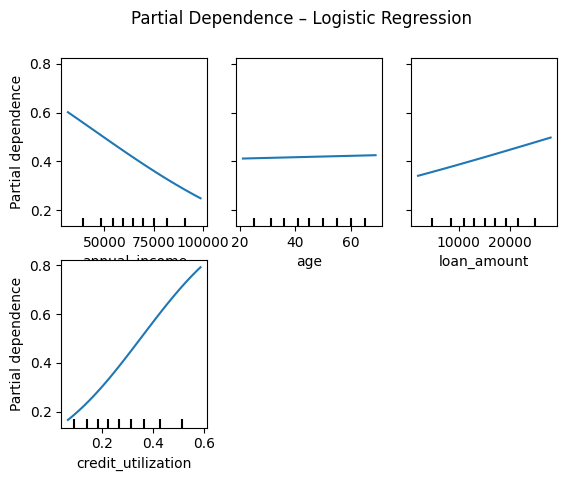

In [25]:
PartialDependenceDisplay.from_estimator(
    logit,
    X_train,
    features=features_to_plot,
    kind="average",
    grid_resolution=50
)

plt.suptitle("Partial Dependence – Logistic Regression")
plt.show()


Interpretation Guidelines

- Straight lines → linear relationship

- Slopes → direction of risk

- Plateaus → saturation effects

📌 Logistic regression PDPs reflect linear decision logic

## PDP for Random Forest

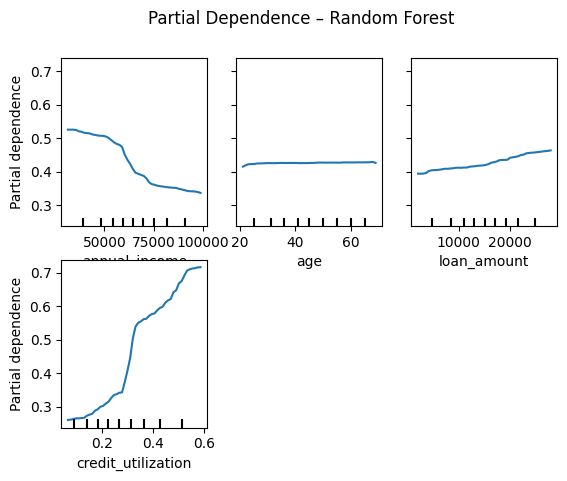

In [28]:
PartialDependenceDisplay.from_estimator(
    rf,
    X_train,
    features=features_to_plot,
    kind="average",
    grid_resolution=50
)

plt.suptitle("Partial Dependence – Random Forest")
plt.show()


#### Interpretation Guidelines

- Non-linear shapes → threshold effects

- Flat regions → ignored ranges

- Sharp jumps → tree split behavior

📌 Tree models often capture business rules implicitly

## Compare Model Behavior


| Feature            | Logistic Regression | Random Forest        |
| ------------------ | ------------------- | -------------------- |
| income             | Linear risk decay   | Threshold saturation |
| credit_utilization | Monotonic           | Non-linear spikes    |
| age                | Smooth              | Flat then jump       |
| loan_amount        | Constant slope      | Risk cliffs          |


📌 Differences indicate model inductive bias

## Two-Way Partial Dependence (Interactions)

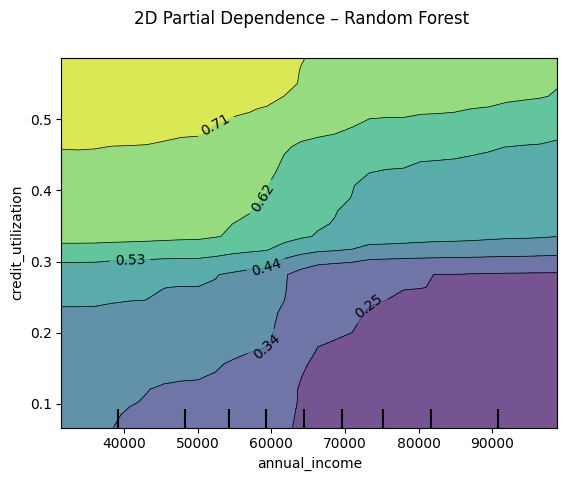

In [35]:
PartialDependenceDisplay.from_estimator(
    rf,
    X_train,
    features=[("annual_income", "credit_utilization")],
    grid_resolution=30
)

plt.suptitle("2D Partial Dependence – Random Forest")
plt.show()


## When to Use 2D PDPs

- ✔ Suspected feature interaction
- ✔ Business-known dependencies
- ✔ Policy boundary analysis

- ❌ High-dimensional explanations

##  Common Pitfalls (Avoided)

- ❌ Interpreting PDP as causal
- ❌ Using correlated features blindly
- ❌ Over-interpreting extremes
- ❌ Applying PDP to sparse categories
- ❌ Ignoring population density

##  Best Practices

- ✔ Select top features only
- ✔ Compare across models
- ✔ Pair with ICE plots
- ✔ Validate with SHAP
- ✔ Document assumptions

##  PDP vs Other Methods

| Method       | Answers               | Scope          |
| ------------ | --------------------- | -------------- |
| Coefficients | Direction & magnitude | Global         |
| Permutation  | Performance impact    | Global         |
| PDP          | Shape of effect       | Global         |
| SHAP         | Contribution          | Global + Local |


## Key Takeaways

- PDPs explain how features influence predictions

- Best used for policy-level explanations

- Model-specific behavior is expected

- Must be paired with importance metrics

- Not a causal tool

## Next Notebooks
[08_Interpretability_and_Explainability/]()

├── [02_local_interpretability/]()

│   ├── [01_shap_values.ipynb](01_shap_values.ipynb)

│   └── [02_lime_explanations.ipynb](02_lime_explanations.ipynb)